In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
import random
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# Load Oil Prices
oil = yf.download('CL=F', start='2010-01-01', end='2023-05-22')
oil = oil.reset_index()
oil = oil[['Date', 'Adj Close']]
oil.rename(columns={'Adj Close' : 'Oil price'}, inplace=True)
print(oil.tail())

# Load Gold Prices
gold = yf.download('GC=F', start='2010-01-01', end='2023-05-22')
gold = gold.reset_index()
gold = gold[['Date', 'Adj Close']]
gold.rename(columns={'Adj Close' : 'Gold price'}, inplace=True)
print(gold.tail())
merged_oil_gold = oil.merge(gold, on='Date', how='inner')
merged_oil_gold.tail()


[*********************100%***********************]  1 of 1 completed
           Date  Oil price
3364 2023-05-15  71.110001
3365 2023-05-16  70.860001
3366 2023-05-17  72.830002
3367 2023-05-18  71.860001
3368 2023-05-19  71.550003
[*********************100%***********************]  1 of 1 completed
           Date   Gold price
3362 2023-05-15  2018.000000
3363 2023-05-16  1988.400024
3364 2023-05-17  1980.699951
3365 2023-05-18  1956.500000
3366 2023-05-19  1978.699951


,Date,Oil price,Gold price
3362,2023-05-15,71.110001,2018.000000
3363,2023-05-16,70.860001,1988.400024
3364,2023-05-17,72.830002,1980.699951
3365,2023-05-18,71.860001,1956.500000
3366,2023-05-19,71.550003,1978.699951


In [6]:
import matplotlib.pyplot as plt

def plot_time_series(df, date_column, column_name):
    # Convert the 'date_column' to datetime if it's not already
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Sort the DataFrame by date
    df = df.sort_values(by=date_column)

    # Get all the unique symbols
    symbols = df['Symbol'].unique()

    plt.figure(figsize=(12, 6))

    for symbol in symbols:
        symbol_df = df[df['Symbol'] == symbol]
        plt.plot(symbol_df[date_column], symbol_df[column_name], label=symbol)

    plt.title(f'Time Series Plot of {column_name} for all symbols', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(column_name, fontsize=14)
    plt.grid(True)
    plt.show()

def plot_log_diff(df, value_column):
    # Normalize the values
    scaler = MinMaxScaler()
    df[value_column] = scaler.fit_transform(df[value_column].values.reshape(-1, 1))
    
    # Calculate log differences
    df['Log Diff'] = np.log(df[value_column]) - np.log(df[value_column].shift(1))
    df = df.dropna()  # drop NaN values
    
    # Plot the log differences
    plt.figure(figsize=(12, 6))
    plt.plot(df['Log Diff'])
    plt.title('Log Differences of Normalized Values', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Log Differences', fontsize=14)
    plt.grid(True)
    plt.show()


In [6]:
random.seed(40)

tickers = pd.read_csv('../CSV/S&P500_opincome.csv')
tickers = [i for i in tickers['Symbol']]

tickers = random.sample(tickers, 5)
tickers = " ".join(tickers)

In [ ]:
tickers

In [2]:
Symbol = 'SCL.TO'
ticker_data = yf.download(Symbol, start='2010-01-01', end='2023-05-22')
df = ticker_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [7]:
df_prices = ticker_data['Adj Close'].reset_index()
df_prices = df_prices.melt(id_vars='Date', var_name='Symbol', value_name='Adj Close')

df_volume = ticker_data['Volume'].reset_index()
df_volume = df_volume.melt(id_vars='Date', var_name='Symbol', value_name='Volume')

df= df_prices.merge(df_volume, on=['Date', 'Symbol'], how='left')
df = df[['Date', 'Symbol', 'Adj Close', 'Volume']]
df['Symbol'] =df['Symbol'].astype(str)

In [3]:
# Use if single ticker
df = ticker_data.reset_index()
date_df = df.copy()
date_df["Symbol"] = Symbol
start_date = df['Date'].min()
df['Time'] = (df['Date'] - start_date).dt.days
df = df[['Adj Close', 'Time']].copy()

In [8]:
# Merge Oil and Gold Data with Ticker information
df = df.merge(merged_oil_gold, on='Date', how='left')

start_date = df['Date'].min()

# Convert each date into the number of days since the start date
df['Time'] = (df['Date'] - start_date).dt.days

In [4]:
df

,Adj Close,Time
0,22.287218,0
1,21.897282,1
2,22.172539,2
3,22.738312,3
4,22.677145,4
...,...,...
3353,14.000000,4879
3354,13.740000,4880
3355,14.350000,4881
3356,14.700000,4882


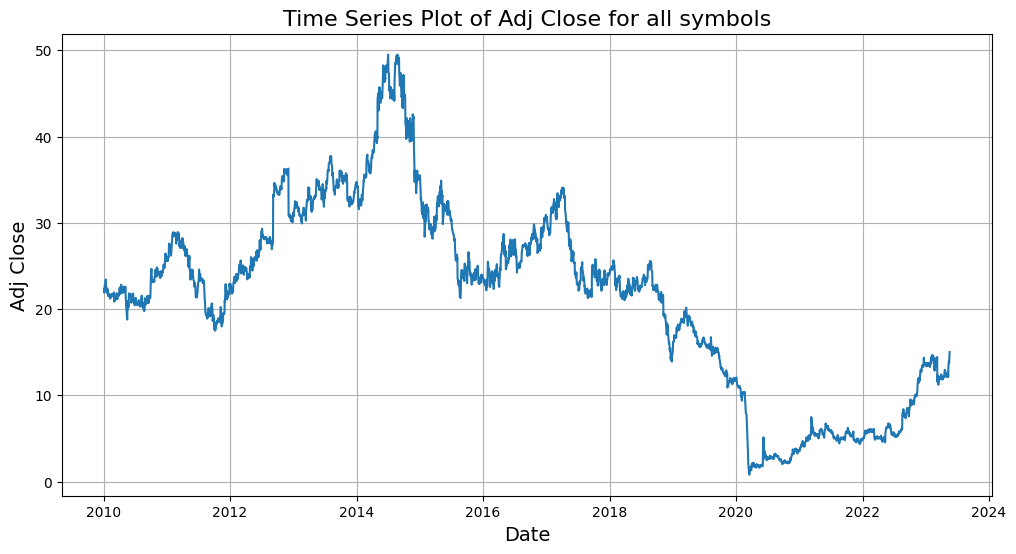

In [7]:
plot_time_series(date_df, 'Date', 'Adj Close')

In [25]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
import torch.nn.functional as F
import torch
from torch.utils.data import TensorDataset, DataLoader

# Calculate 30 days rolling average and add it as a new column 'Rolling Average'
def add_rolling_avg(df):
    df = df.copy()
    df['Rolling Average'] = df['Adj Close'].rolling(window=30).mean()
    return df

# Preprocess data
def preprocess_data(df, window_size):
    df = df.copy()

    # Calculate the log differences
    df['Adj Close'] = np.log1p(df['Adj Close']).diff()
    df = add_rolling_avg(df)

    # Drop rows with NaN values
    df = df.dropna()

    # Scale the values
    scaler = MinMaxScaler()
    df.loc[:, ['Adj Close', 'Rolling Average']] = scaler.fit_transform(df[['Adj Close', 'Rolling Average']])

    sequences = []
    targets = []

    # Create sequences
    for i in range(len(df) - window_size):
        sequences.append(df[['Adj Close', 'Rolling Average', 'Time']].iloc[i: i + window_size].values)
        targets.append(df['Adj Close'].iloc[i + window_size])

    # Convert sequences and target to numpy arrays
    sequences = np.array(sequences)
    targets = np.array(targets)

    return sequences, targets, scaler

# Create dataloader
def create_dataloader(sequences, targets, batch_size):
    # Convert to PyTorch tensors
    sequences_tensor = torch.tensor(sequences).float()
    targets_tensor = torch.tensor(targets).float()

    # Create dataset and dataloader
    dataset = TensorDataset(sequences_tensor, targets_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return dataloader

def t2v(tau, f, out_features, w, b, w0, b0):
    # Apply sinusoidal transformation with learnable parameters
    v1 = f(torch.matmul(tau, w) + b)
    # Apply linear transformation with learnable parameters
    v2 = torch.matmul(tau, w0) + b0
    # Concatenate the results
    return torch.cat([v1, v2], -1)

class Time2Vec(nn.Module):
    def __init__(self, in_features, out_features):
        super(Time2Vec, self).__init__()
        self.out_features = out_features
        
        # Learnable parameters for the sinusoidal transformation
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(out_features-1))

        # Learnable parameters for the linear transformation
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        # Sinusoidal activation function
        self.f = torch.sin

    def forward(self, tau):
        return t2v(tau, self.f, self.out_features, self.w, self.b, self.w0, self.b0)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model, nhead, nhid, nlayers, dropout=.1):
        super(TransformerModel, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.d_model = d_model
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.time2vec = Time2Vec(1, 2)  # Add Time2Vec layer
        self.input_layer = nn.Sequential(
        nn.Linear(input_dim+1, 5086),  # First layer
        nn.LayerNorm(5086),
        nn.ReLU(),
        nn.Linear(5086, 2048),  # Second layer
        nn.LayerNorm(2048),
        nn.ReLU(),
        nn.Linear(2048, nhid),  # Third layer
        nn.LayerNorm(nhid),
        nn.ReLU(),
        nn.Linear(nhid, d_model),  # Fourth layer
        nn.LayerNorm(d_model))
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, nhid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.fc = nn.Sequential(
            nn.Linear(d_model, 2048),
            nn.ReLU(),
            nn.LayerNorm(2048),
            nn.Linear(2048, 524),
            nn.LayerNorm(524),
            nn.ReLU(),
            nn.Linear(524, 100),
            nn.ReLU(),
            nn.LayerNorm(100),
            nn.Linear(100, 1)
        )
        
        # Apply Xavier initialization
        nn.init.xavier_uniform_(self.input_layer[0].weight)
        for layer in self.fc:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)


    def forward(self, src):
        # Separate time feature
        time_feature = src[:, :, -1:]  # Assuming 'Time' is the last feature
        other_features = src[:, :, :-1]

        # Apply Time2Vec to time feature
        time_feature = self.time2vec(time_feature)

        # Concatenate Time2Vec output with other features
        src = torch.cat((other_features, time_feature), -1)

        src = self.input_layer(src)
        src = self.pos_encoder(src)
        src = self.transformer_encoder(src)

        # Apply Global Average Pooling 1D
        src = F.adaptive_avg_pool1d(src.permute(0, 2, 1), 1).view(src.size(0), -1)

        # Apply the fully connected network to the output of GAP layer
        output = self.fc(src)
        return output.squeeze()

def train_model(dataloader, model, criterion, optimizer, device):
    model.train()
    total_loss = 0.

    for sequences, target in dataloader:
        sequences = sequences.to(device)
        target = target.to(device)
        
        # Change how the target tensor is reshaped
        target = target.reshape(-1)
        
        optimizer.zero_grad()
        output = model(sequences)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def save_model(model, path):
    torch.save(model.state_dict(), path)

# Hyperparameters
window_size = 15
batch_size = 150
n_epochs = 40

# Preprocess data
sequences, target, scaler = preprocess_data(df, window_size)

# Create dataloader
dataloader = create_dataloader(sequences, target, batch_size)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model, criterion, and optimizer
model = TransformerModel(d_model=600, input_dim=3, output_dim=1, nhead=12, nhid=1200, nlayers=16).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=.00001)

In [26]:
# Training loop
for epoch in range(n_epochs):
    loss = train_model(dataloader, model, criterion, optimizer, device)
    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss:.6f}")

# Save the trained model
save_model(model, 'trained_model.pth')

Epoch [1/40], Loss: 0.326321
Epoch [2/40], Loss: 0.008269
Epoch [3/40], Loss: 0.004211
Epoch [4/40], Loss: 0.004141
Epoch [5/40], Loss: 0.003328
Epoch [6/40], Loss: 0.003258
Epoch [7/40], Loss: 0.003368
Epoch [8/40], Loss: 0.003359
Epoch [9/40], Loss: 0.003211
Epoch [10/40], Loss: 0.003176
Epoch [11/40], Loss: 0.003396
Epoch [12/40], Loss: 0.003103
Epoch [13/40], Loss: 0.002900
Epoch [14/40], Loss: 0.003019
Epoch [15/40], Loss: 0.002845
Epoch [16/40], Loss: 0.002962
Epoch [17/40], Loss: 0.002858
Epoch [18/40], Loss: 0.002880
Epoch [19/40], Loss: 0.002588
Epoch [20/40], Loss: 0.002662
Epoch [21/40], Loss: 0.002734
Epoch [22/40], Loss: 0.002585
Epoch [23/40], Loss: 0.002618
Epoch [24/40], Loss: 0.002578
Epoch [25/40], Loss: 0.002539
Epoch [26/40], Loss: 0.002510
Epoch [27/40], Loss: 0.002773
Epoch [28/40], Loss: 0.002411
Epoch [29/40], Loss: 0.002409
Epoch [30/40], Loss: 0.002678
Epoch [31/40], Loss: 0.002390
Epoch [32/40], Loss: 0.002430
Epoch [33/40], Loss: 0.002447
Epoch [34/40], Loss

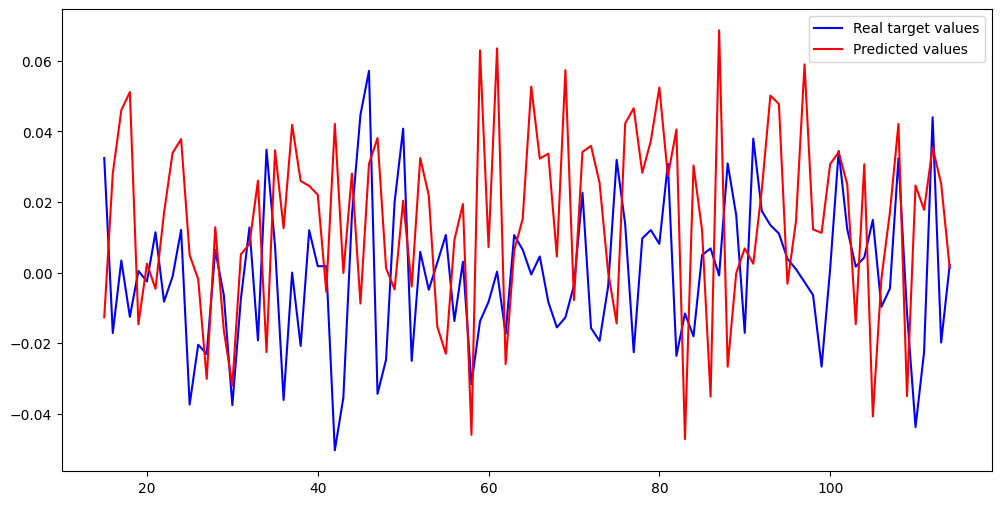

In [27]:
def plot_sequences_targets_predictions(sequences, targets, model, scaler):
    plt.figure(figsize=(12, 6))

    # Plot the next 100 target values in blue (from 300 to 400)
    temp_targets = np.zeros((100, 2))
    temp_targets[:, 0] = targets[1200:1300]
    real_targets = scaler.inverse_transform(temp_targets)[:, 0]
    plt.plot(range(window_size, window_size + 100), real_targets, color='blue', label='Real target values')

    # Use the model to predict the next 100 values (from 300 to 400) and plot in red
    with torch.no_grad():
        predictions = []
        for i in range(1200, 1300):
            seq_tensor = torch.Tensor(sequences[i]).unsqueeze(0).to(device)
            output = model(seq_tensor)
            predictions.append(output.item())
        temp_predictions = np.zeros((100, 2))
        temp_predictions[:, 0] = predictions
        real_predictions = scaler.inverse_transform(temp_predictions)[:, 0]
        plt.plot(range(window_size, window_size + 100), real_predictions, color='red', label='Predicted values')

    plt.legend()
    plt.show()

# Call the function
plot_sequences_targets_predictions(sequences, target, model, scaler)



In [26]:
sequences.shape

(129487, 60, 5)

In [27]:
target.shape

(129487,)